In [1]:
from ipywidgets import FloatProgress, Layout
from IPython.display import display
import micasense.imageset as imageset
import micasense.capture as capture
import os, glob
import multiprocessing


import warnings

warnings.simplefilter(action='ignore') #, category=FutureWarning)


panelNames = None
useDLS = True

# imagePath = os.path.expanduser(os.path.join('~','Downloads','RedEdgeImageSet','0000SET'))
# panelNames = glob.glob(os.path.join(imagePath,'000','IMG_0000_*.tif'))
# panelCap = capture.Capture.from_filelist(panelNames)

# # Image from the example RedEdge imageSet (see the ImageSet notebook) without RigRelatives.
# imagePath = os.path.expanduser(os.path.join('/home/cvg-ws05/msi_up/nikhil/MSI/data/micasense_datasets/Part1','000'))
# imageNames = glob.glob(os.path.join(imagePath,'IMG_0015_*.tif'))  # sets to be aligned
# panelNames = glob.glob(os.path.join(imagePath,'IMG_0000_*.tif'))  # corresponding CRP images for metadata

# Image from the example RedEdge imageSet (see the ImageSet notebook) without RigRelatives.
imagePath = os.path.expanduser(os.path.join('/home/cvg-ws05/msi_up/nikhil/MSI/data/micasense_datasets/Part1','005'))
imagePath_panel = os.path.expanduser(os.path.join('/home/cvg-ws05/msi_up/nikhil/MSI/data/micasense_datasets/Part1','000'))
imageNames = glob.glob(os.path.join(imagePath,'IMG_0003_*.tif'))  # sets to be aligned
panelNames = glob.glob(os.path.join(imagePath_panel,'IMG_0000_*.tif'))  # corresponding CRP images for metadata


outputPath = os.path.join(imagePath,'..','stacks')  # to save stacks
thumbnailPath = os.path.join(outputPath, '..', 'thumbnails')  # to save registered composite RGB images
# channel_path = os.path.join(outputPath, '..','channels')  # to save registered MS channels

overwrite = False # can be set to set to False to continue interrupted processing
generateThumbnails = True
export_channels = True

# Allow this code to align both radiance and reflectance images; bu excluding
# a definition for panelNames above, radiance images will be used
# For panel images, efforts will be made to automatically extract the panel information
# but if the panel/firmware is before Altum 1.3.5, RedEdge 5.1.7 the panel reflectance
# will need to be set in the panel_reflectance_by_band variable.
# Note: radiance images will not be used to properly create NDVI/NDRE images below.
# print(len(imageNames))
if panelNames is not None:
    panelCap = capture.Capture.from_filelist(panelNames)
else:
    panelCap = None

if panelCap is not None:
    if panelCap.panel_albedo() is not None and not any(v is None for v in panelCap.panel_albedo()):
        panel_reflectance_by_band = panelCap.panel_albedo()
    else:
        panel_reflectance_by_band = [0.67, 0.69, 0.68, 0.61, 0.67] #RedEdge band_index order
    
    panel_irradiance = panelCap.panel_irradiance(panel_reflectance_by_band)    
    img_type = "reflectance"
else:
    if useDLS:
        img_type='reflectance'
    else:
        img_type = "radiance"

# print(len(panelNames))
# print(len(imageNames))

In [2]:
## This progress widget is used for display of the long-running process
f = FloatProgress(min=0, max=1, layout=Layout(width='100%'), description="Loading")
display(f)
def update_f(val):
    if (val - f.value) > 0.005 or val == 1: #reduces cpu usage from updating the progressbar by 10x
        f.value=val

%time imgset = imageset.ImageSet.from_directory(imagePath, progress_callback=update_f)
update_f(1.0)

FloatProgress(value=0.0, description='Loading', layout=Layout(width='100%'), max=1.0)

Loading ImageSet from: /home/cvg-ws05/msi_up/nikhil/MSI/data/micasense_datasets/Part1/005
CPU times: user 8.4 s, sys: 185 ms, total: 8.59 s
Wall time: 23.2 s


In [ ]:
import math
import numpy as np
from mapboxgl.viz import *
from mapboxgl.utils import df_to_geojson, create_radius_stops, scale_between
from mapboxgl.utils import create_color_stops
import pandas as pd


data, columns = imgset.as_nested_lists()
df = pd.DataFrame.from_records(data, index='timestamp', columns=columns)

#Insert your mapbox token here
token = 'pk.eyJ1IjoibWljYXNlbnNlIiwiYSI6ImNqYWx5dWNteTJ3cWYzMnBicmZid3g2YzcifQ.Zrq9t7GYocBtBzYyT3P4sw'
color_property = 'dls-yaw'
num_color_classes = 8

min_val = df[color_property].min()
max_val = df[color_property].max()

import jenkspy
breaks = jenkspy.jenks_breaks(df[color_property], nb_class=num_color_classes)

color_stops = create_color_stops(breaks,colors='YlOrRd')
geojson_data = df_to_geojson(df,columns[3:],lat='latitude',lon='longitude')

viz = CircleViz(geojson_data, access_token=token, color_property=color_property,
                color_stops=color_stops,
                center=[df['longitude'].median(),df['latitude'].median()], 
                zoom=16, height='600px',
                style='mapbox://styles/mapbox/satellite-streets-v9')
viz.show()

In [4]:
from numpy import array
from numpy import float32
import numpy as np

# Set warp_matrices to none to align using RigRelatives
# Or
# Use the warp_matrices derived from the Alignment Tutorial for this RedEdge set without RigRelatives
# warp_matrices = [array([[ 1.0022864e+00, -2.5218755e-03, -7.8898020e+00],
#        [ 2.3614739e-03,  1.0036649e+00, -1.3134377e+01],
#        [-1.7785899e-06,  1.1343118e-06,  1.0000000e+00]], dtype=float32), array([[1., 0., 0.],
#        [0., 1., 0.],
#        [0., 0., 1.]], dtype=float32), array([[ 9.9724638e-01, -1.5535230e-03,  1.2301294e+00],
#        [ 8.6745428e-04,  9.9738181e-01, -1.6499169e+00],
#        [-8.2816513e-07, -3.4488804e-07,  1.0000000e+00]], dtype=float32), array([[ 1.0007139e+00, -8.4427800e-03,  1.6312805e+01],
#        [ 6.2834378e-03,  9.9977130e-01, -1.6011697e+00],
#        [-1.9520389e-06, -6.3762940e-07,  1.0000000e+00]], dtype=float32), array([[ 9.9284178e-01,  9.2155562e-04,  1.6069822e+01],
#        [-3.2895457e-03,  9.9262553e-01, -5.0333548e-01],
#        [-1.5845577e-06, -1.7680986e-06,  1.0000000e+00]], dtype=float32)]

warp_matrices = np.load('/home/cvg-ws05/msi_up/nikhil/MSI/data/micasense_datasets/Part1/warp_matrices.npy')
print(warp_matrices)

[[[ 9.97984886e-01  3.81712429e-03  1.07992115e+01]
  [-6.74913172e-03  9.97700870e-01  3.42201495e+00]
  [-1.97412533e-06 -2.60883166e-06  1.00000000e+00]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 1.00010180e+00  2.66201183e-04  1.63180866e+01]
  [-9.85691557e-04  1.00021434e+00  5.54913330e+00]
  [-1.12014561e-06  3.09240278e-08  1.00000000e+00]]

 [[ 1.00028038e+00  1.76764990e-03  8.68098068e+00]
  [-6.42794836e-03  1.00033152e+00  4.81351042e+00]
  [-3.09991037e-06 -4.81653478e-06  1.00000000e+00]]

 [[ 1.00238883e+00  1.90657005e-03  2.14406090e+01]
  [-2.86875595e-03  9.99445796e-01  5.21580172e+00]
  [ 1.80997154e-06 -3.36434141e-06  1.00000000e+00]]]


In [13]:
import exiftool
import datetime
## This progress widget is used for display of the long-running process
f2 = FloatProgress(min=0, max=1, layout=Layout(width='100%'), description="Saving")
display(f2)
def update_f2(val):
    f2.value=val

# check if output directories exist, else create
if not os.path.exists(outputPath):
    os.makedirs(outputPath)  # for stacks
if generateThumbnails and not os.path.exists(thumbnailPath):
    os.makedirs(thumbnailPath)  # for RGB images 



# Save out geojson data so we can open the image capture locations in our GIS
with open(os.path.join(outputPath,'imageSet.json'),'w') as f:
    f.write(str(geojson_data))
    
try:
    irradiance = panel_irradiance+[0]
except NameError:
    irradiance = None

start = datetime.datetime.now()
# print("length: ",len(imgset.captures))

for i,capture in enumerate(imgset.captures):
    outputFilename = capture.uuid+'.tif'
    thumbnailFilename = capture.uuid+'.jpg'
    # channel_file_name = capture.uuid+'.tif'
    fullOutputPath = os.path.join(outputPath, outputFilename)
    fullThumbnailPath= os.path.join(thumbnailPath, thumbnailFilename)
    if (not os.path.exists(fullOutputPath)) or overwrite:
        if(len(capture.images) == len(imgset.captures[0].images)):
            capture.create_aligned_capture(irradiance_list=irradiance, warp_matrices=warp_matrices)
            capture.save_capture_as_stack(fullOutputPath)
            if generateThumbnails:
                capture.save_capture_as_rgb(fullThumbnailPath)
    capture.clear_image_data()
    update_f2(float(i)/float(len(imgset.captures)))
update_f2(1.0)
end = datetime.datetime.now()

print("Saving time: {}".format(end-start))
print("Alignment+Saving rate: {:.2f} images per second".format(float(len(imgset.captures))/float((end-start).total_seconds())))

FloatProgress(value=0.0, description='Saving', layout=Layout(width='100%'), max=1.0)

Saving time: 0:04:41.326748
Alignment+Saving rate: 0.71 images per second


In [28]:
print(len(imgset.captures[0].images))
ch1 = imgset.captures[0].images[0]
import numpy as np
np.save("test_batch.npy", imgset.captures[0].images)

5


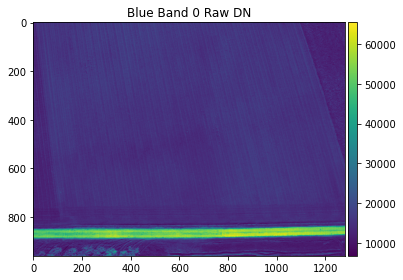

In [33]:
dataa = np.load('test_batch.npy', allow_pickle=True)
dataa[0].plot_raw();

In [34]:
import hdf5storage
def save_matv73(mat_name, var_name, var):
    hdf5storage.savemat(mat_name, {var_name: var}, format='7.3', store_python_metadata=True)

In [35]:
def save_capture_as_mat():
    save_matv73('sample_batch', 'cube', capture.create_aligned_capture(irradiance_list=irradiance, warp_matrices=warp_matrices))
    
save_capture_as_mat()

In [ ]:
for i in range(len(imgset.captures)):
    print(len(imgset.captures[i].images))
    save_matv73('batch_{}'.format(i), 'cube', capture.create_aligned_capture(irradiance_list=irradiance, warp_matrices=warp_matrices))

200
5


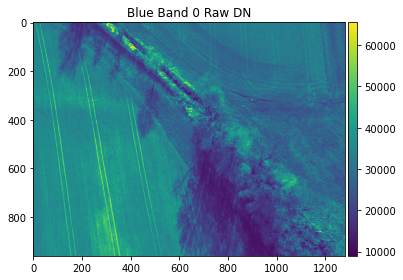

(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:title={'center':'Blue Band 0 Raw DN'}>)

In [61]:
print(len(imgset.captures))
print(len(imgset.captures[0].images))
# print(len(capture.images))
imgset.captures[199].images[0].plot_raw()